This notebook extracts citations from each single-issue BVA decision text into a structured json and writes it to GCP.

The second part of the notebook analyses the citations.

In [3]:
import pymongo
import os
os.chdir('/bva-data/')
from db_config import *

# connect to mongo database
db = pymongo.MongoClient(host=DB_HOST, port=DB_PORT)[DB_DATABASE]
db.authenticate(DB_USER, DB_PASSWORD)

True

In [14]:
# Load Libraries
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import date2num
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime as dt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rc('font', size=12)
pd.options.mode.chained_assignment = None   # To prevent warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# List collections in DB
for name in db.list_collection_names():
    print(f"{name}: {db[name].estimated_document_count():,}")

answer-feedback: 1
appeals_meta_old: 1,907,349
annotations: 330
citations: 1,024,074
answer.feedback: 25,367
users: 117
code_dictionary: 3
appeals_meta: 2,261,400
documents: 1,024,074
appeals_meta_wscraped: 2,261,400


In [ ]:
%%capture
from dask.distributed import Client, LocalCluster
from dask import delayed
import numpy as np
import dask.bag as daskdb
import time
import re
import random
import glob
import pandas as pd
import json
import math

class Timer():
    def start(self):
        self.start_time = time.time()
    
    def end(self):
        self.end_time = time.time()
        diff = self.end_time - self.start_time
        if diff > 60:
            minutes = math.floor(diff / 60)
            print(f"Time elapsed: {minutes:,} mins {diff - minutes*60:.2f} seconds.")
        else:
            print(f"Time elapsed: {diff:.2f} seconds.")
timer = Timer()

### Citation Extraction Code

Below is code used to extract case and statutory citations.

In [ ]:
# Build a pattern to extract statutory citations
case_patt = re.compile('(See\s|See,\se\.g\.,\s|See\salso|)([DeMcO\'Mac]*[A-Z][a-z]+\s[A-Z]?[a-z]*\s?v\.\s[A-Z][a-z]+[,\s]+|)(\d{1,4})\s(F.2d|F.3d|F.|Vet. App.|U.S.|F. Supp.|F.Supp.|F. Supp. 2d|F. Supp. 3d|F.Supp.2d|F.Supp.3d|F. Supp. 2d.|F. Supp. 3d.)(\s|\sat\s)(\d{1,4})[,\s]*(\d{1,4}[,\-\s]*\d*|)[,\-\s]*(\d*|)(\s?\([A-Za-z\.\s]*\d{4}\)|)')
statute_patt = re.compile('([0-9]{1,4}\s)(C.F.R.|U.S.C.A.|U.S.C.|C. F. R.|U. S. C.| U. S. C. A.)\s[\\xa7]*\s*(\d{1,4}[\.,\s]*\d{1,4}[\(\)A-Za-z\d]*)([,\s\d]*)(\([A-Za-z\.\s]*\d{4}\)|)')

# Return a list of citations for a document by the position it occurs in the text
def get_citations(document):      
    """Remove \r, \n and replacement character to better match citations"""

    def find_citation_by_pattern(text, citation_type, pattern, parser):
        return [{"position": m.span(),
                  "type": citation_type, 
                  **parser(m.groups())}\
                    for m in re.finditer(pattern, text)]        

    # Find cases, then statutes
    text = document.pop("txt").replace('\r', '').replace('\n', '').replace('\ufffd', '')
    cases = find_citation_by_pattern(text, "case", case_patt, citeparse)
    statutes = find_citation_by_pattern(text, "statute", statute_patt, statparse)

    # Sort citations by start position
    citations = sorted(cases + statutes, key=lambda k: k['position'][0]) 
    return {"bva_id": document['bva_id'], "citations": citations}

def citeparse(components): 
    """Given a case citation, label its constituent components"""
    components = [item.strip() for item in components]
    signal, caption, volume, reporter, s, startpage, pin1, pin2, year = components
    out = {'signal':signal, # this is an indication of how the authority is being used
           'caption':caption, # title of the cited case
           'volume':volume, # volume of the book where the case is reported
           'reporter':reporter, # case reporter
           'startpage':startpage, # case start page in the reporter
           'pincites':[pin1,pin2], #specific reference in the reporter
           'yr':year, 
           'case': volume + ' ' + reporter + ' ' + startpage}
    return  out

def statparse(components): 
    components = [item.strip() for item in components]
    vol, code, s1, s2, year = components
    # Turn the sections into a list of individual section numbers
    if s2 != '':
        ss = ', '.join([s1,s2]).split(', ')
    elif s2 == '':
        ss = s1.split(', ')
    ss = [x for x in ss if x is not '']
    # create a dict and count refs to each statute section
    out = {'statutes': [' '.join([vol, code, s]) for s in ss],
           'volume': vol,
           'code':code,
           'year': year,
           'sections':ss}
    return  out

def get_citation_list(list_ids):
    citation_list = []

    # Get documents
    documents = db.documents.find(
    {"bva_id": {"$in": list_ids}},
        {"_id": 0, "bva_id": 1, "txt": 1}
    )

    # iterate through all the document texts
    for document in documents:
        citations = get_citations(document)
        citation_list.append(citations)

    return citation_list

### Scraped Data
Before we dive into citations, we look into how the combined data (scraped + VACOLs) `appealed_cavc_appeal_level` helps to improve our existing `appealed_CAVC` variable.

In [ ]:
# filter single issue cases
timer.start()
df_meta = pd.DataFrame(list(db.appeals_meta_wscraped.find({}, {"_id": 0})))
df_meta["timestamp"] = pd.to_datetime(df_meta['imgadtm'], utc=True)
df_meta["issue_count"] = df_meta["issue_count"].astype(int)
single_issue_ids = df_meta[df_meta["issue_count"] == 1].tiread2
single_issue = df_meta.query("issue_count == 1")
single_issue["appealed_CAVC"] = single_issue["appealed_CAVC"].astype(int)
single_issue["appealed_cavc_appeal_level"] = single_issue["appealed_cavc_appeal_level"].astype(int)
single_issue["cvjoint"] = single_issue["cvjoint"].astype(int)
single_issue["jmr_appeal_level"] = single_issue["jmr_appeal_level"].astype(int)
timer.end()

In [ ]:
def plot_compare_time_series(df, target_list):
    plot_data = pd.DataFrame({})
    for target in target_list:
        temp = df.groupby([pd.Grouper(key="timestamp", freq='M')])\
            .agg(count = (target, "count"),
                 appealed = (target, "sum"))\
        .reset_index()
        temp['target'] = target
        plot_data = plot_data.append(temp, ignore_index=True)

    plot_data = plot_data.query("count > 5")      # Omit small counts which have unstable appeal rates
    plot_data["proportion"] = plot_data["appealed"] / plot_data["count"]
    plot_data.sort_values(["target", "timestamp"], inplace=True)
    plot_data["timestamp"] = plot_data["timestamp"].astype("datetime64[ns]")    
    sns.lineplot(data=plot_data, x="timestamp", y="proportion", hue="target", legend=False)
    sns.scatterplot(data=plot_data, x="timestamp", y="proportion", hue="target")
    _ = plt.xlabel("Month")
    return plot_data

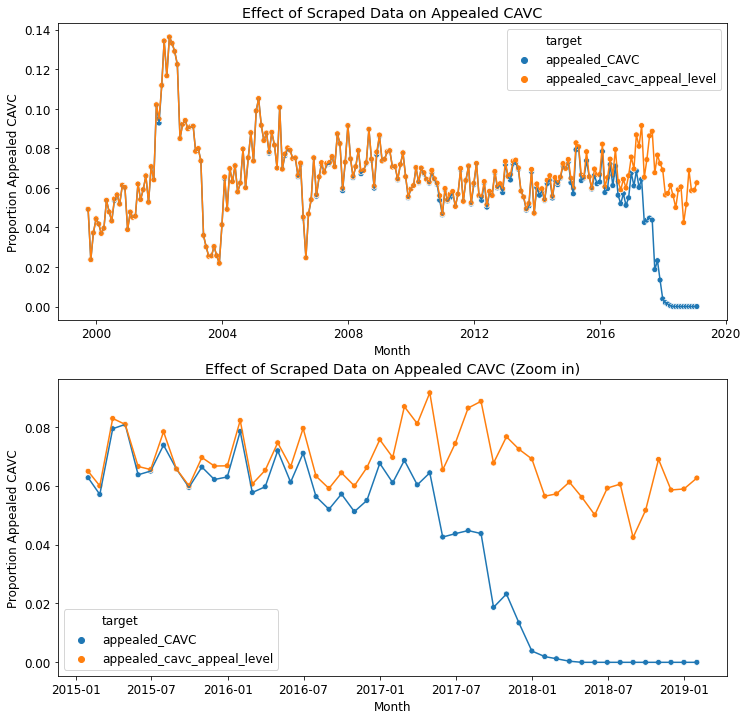

In [56]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.subplot(211)
plot_data = plot_compare_time_series(single_issue, ["appealed_CAVC", "appealed_cavc_appeal_level"])
_ = plt.title("Effect of Scraped Data on Appealed CAVC")
_ = plt.ylabel("Proportion Appealed CAVC")
plt.subplot(212)
plot_data = plot_compare_time_series(single_issue.query("timestamp > @pd.Timestamp('2015-01-01',tz='UTC')"), 
                                 ["appealed_CAVC", "appealed_cavc_appeal_level"])
_ = plt.title("Effect of Scraped Data on Appealed CAVC (Zoom in)")
_ = plt.ylabel("Proportion Appealed CAVC")

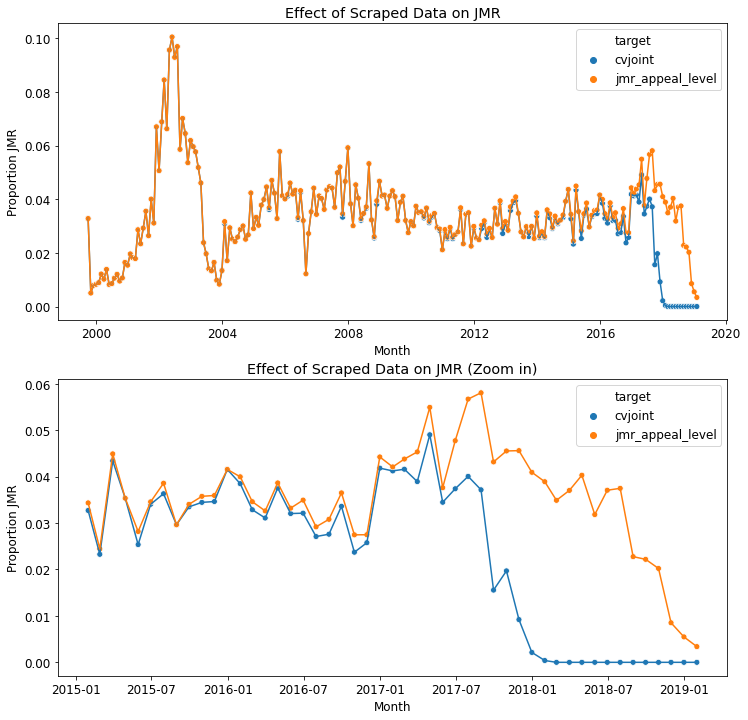

In [57]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.subplot(211)
plot_data = plot_compare_time_series(single_issue, ["cvjoint", "jmr_appeal_level"])
_ = plt.title("Effect of Scraped Data on JMR")
_ = plt.ylabel("Proportion JMR")
plt.subplot(212)
plot_data = plot_compare_time_series(single_issue.query("timestamp > @pd.Timestamp('2015-01-01',tz='UTC')"), 
                                 ["cvjoint", "jmr_appeal_level"])
_ = plt.title("Effect of Scraped Data on JMR (Zoom in)")
_ = plt.ylabel("Proportion JMR")

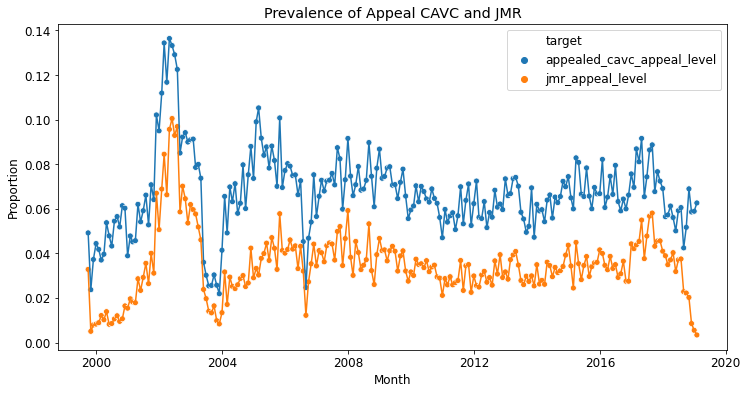

In [58]:
plt.rcParams["figure.figsize"] = [12,6]
plot_data = plot_compare_time_series(single_issue, ["appealed_cavc_appeal_level", "jmr_appeal_level"])
_ = plt.title("Prevalence of Appeal CAVC and JMR")
_ = plt.ylabel("Proportion")

### Extract Citations
Now we can extract citations for single issue cases.

In [59]:
print(f"There are {single_issue_ids.shape[0]:,} single issue cases.")
print(f"However, there are only {len(np.unique(single_issue_ids)):,} unique bva ids.")

There are 386,168 single issue cases.
However, there are only 386,151 unique bva ids.


In [70]:
# Compute Citations
timer.start()
list_ids = random.sample(list(single_issue_ids), 30)
citation_list = get_citation_list(list_ids)
timer.end()

Time elapsed: 0.73 seconds.


### Visualize Citations

Next, we will visualize some bva texts to examine whether the citation detection is accurate. This will write out .html files which can be viewed with the browser.

In [ ]:
def write_citation_html(citation_object, outfile):

    # Look up document
    bva_id = citation_object["bva_id"]
    text = db.documents.find_one(
        {"bva_id": bva_id},
        {"_id": 0, "txt": 1}
    )["txt"].replace('\r', '').replace('\n', '').replace('\ufffd', '')
    text_length = len(text)

    # Colors
    red = "rgb(235,76,52)"
    blue = "rgb(52,98,235)"

    # Create HTML with Highlighted Citations
    html_text = "<!DOCTYPE html><html>"
    html_text += "<div style='max-width:1000px;font-size:16px;line-height:1.3em;position:relative;margin:1em auto 4em auto'>"
    html_text += f"Citations for BVA ID: {bva_id}<br/><br/>"
    start = 0
    for i, citation in enumerate(citation_object["citations"]):
        cite_start, cite_end = citation["position"]
        html_text += text[start:cite_start]
        text_color = red if citation["type"] == "case" else blue
        html_text += f" <span style='color:{text_color}'>{text[cite_start:cite_end]}</span>"
        start = cite_end
    html_text += f"{text[start:text_length]}</div></html>"

    # Write
    with open(outfile, "w") as f:
        f.write(html_text)

# Write a sample of HTML visualising citations
# !rm -r citation_viz
# !mkdir citation_viz
# for i, citation in enumerate(citation_list):
#     bva_id = citation["bva_id"]
#     write_citation_html(citation, f"citation_viz/{bva_id}.html")

### Appealable Cases

We are interested in which case types are appealable, so that we can find a good base group to compare appeal rates within.

In [ ]:
# Utility code to encode metadata codes
from functools import reduce
class Dictionary():
    def __init__(self):
        self.issue_dict = db.code_dictionary.find_one({"name": "issue"})['dict']
        self.issdc_dict = db.code_dictionary.find_one({"name": "issdc"})['dict']
        self.cvdisp_dict = db.code_dictionary.find_one({"name": "cvdisp"})['dict']
        self.issue_levels = ["issprog", "isscode", "isslev1", "isslev2", "isslev3"]

    # Given issue codes, return the relevant label
    def label_issue(self, **kwargs):
        list_conditions = []
        try:
            for var in self.issue_levels:
                if var in kwargs:
                    list_conditions.append(var)
                    list_conditions.append(str(kwargs[var]))
            label = reduce(dict.__getitem__, list_conditions + ["label"], self.issue_dict)
        except:
            label = ''
        return label

    # Given issdc code, return label
    def label_issdc(self, issdc):
        try:
            return self.issdc_dict["issdc"][str(issdc)]['label']
        except:
            return ''

    # Given cvdisp code, return label
    def label_cvdisp(self, cvdisp):
        try:
            return self.cvdisp_dict["cvdisp"][str(cvdisp)]['label']
        except:
            return ''

dictionary = Dictionary()

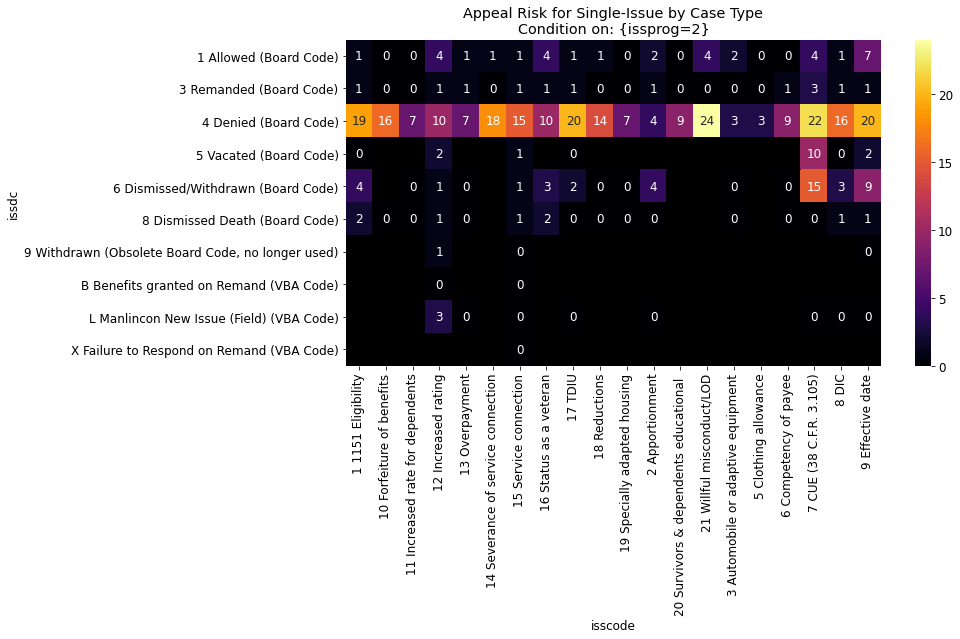

In [74]:
def plot_appeal_rate_heatmap(df, axis1, axis2):
    temp = df.groupby([axis1, axis2])\
            .agg(count = ("appealed_CAVC", "count"),
                 appealed = ("appealed_CAVC", "sum"))\
            .reset_index()

    temp["proportion"] = np.ceil(temp["appealed"] / temp['count'] * 100)
    temp = temp.query("count > 10 & issdc != ''")
    temp = temp.pivot(axis1, axis2, "proportion")
    cmap = plt.get_cmap("inferno")
    cmap.set_bad("black")
    sns.heatmap(data=temp, annot=True, cmap=cmap, fmt=".0f", vmin=0)

    # Adjust labels
    ax = plt.gca()
    curr_xlabel = [x.get_text() for x in ax.get_xticklabels()]
    new_xlabel = [f"{x} {dictionary.label_issue(issprog=2, isscode=x)[0:35]}" for x in curr_xlabel]
    curr_ylabel = [y.get_text() for y in ax.get_yticklabels()]
    new_ylabel = [f"{y} {dictionary.label_issdc(y)}" for y in curr_ylabel]
    _ = ax.set_xticklabels(new_xlabel)
    _ = ax.set_yticklabels(new_ylabel)
    _ = plt.xticks(rotation=90)
    _ = plt.yticks(rotation=0)

plot_appeal_rate_heatmap(single_issue.query("issprog=='2'"), "issdc", "isscode")
_ = plt.title("Appeal Risk for Single-Issue by Case Type\nCondition on: {issprog=2}")

### Analyze Important Citations

Now that we have obtained the extracted citations, we can search for the 4 important citations and parse it into structured data. Based on David Ames' descriptions, here are 4 important citations:

**Thun v. Peake, 22 Vet.App. 111 (2009)**
*   Case Date: April 23, 2008
*   This is likely a very interesting case for study. I do not know how fast it got cited, but it became near-ubiquitous in increased rating (IR) claims eventually. Its use then plummeted following a Board training conducted in August 2017, which advised against its use.

**Scott v. McDonald, 789 F.3d 1375 (Fed. Cir. 2015)**
*   Case Date: June 18, 2015
*   Case likely did not initially get much attention, so I expect uptake rate would be low for a while. It slowly started to gain traction with the Board, resulting in me issuing guidance on how to approach it twice. Those guidance emails were dated July 31, 2017, and December 8, 2017. I also gave a training to judges which discussed proper use of Scott in May 2017 (precise day unknown). This may be an example of a slow uptake case, which then accelerated at some point in 2016 or 2017.

**Johnson v. McDonald, 762 F.3d 1362 (Fed. Cir. 2014)**
*   Case Date: August 6, 2014
*   This is an interesting case that for a time became a companion case (and cite) to Thun. However, it was on a slightly different aspect of the regulation, and therefore stood independently. This case would be interesting to examine as Thun was already in heavy use by the time Johnson came around, and so it may have been taken up more quickly just due to general awareness of Thun. However, the regulation that was the basis of Johnson was changed effective December 8, 2017, effectively eliminating Johnson. So, an analysis of Johnson would also look to the speed of the decline in citations to it following the reg change.

**Saunders v. Wilkie, 886 F.3d 1356 (2018)**

*   Case Date: April 3, 2018
*   While a major case in its own right, Saunders is notable for explicitly overruling Sanchez-Benitez v. West, 13 Vet. App. 282 (1999). Sanchez-Benitez was a widely cited case for a certain proposition, so one thing to look for is how fast citations to Sanchez-Benitez stop after the release of Saunders.

### Thun v. Peake
Here we go in depth and explore Thun v. Peake citations.

In [ ]:
def find_cases_that_cite(citation):
    """
    Given a citation, find all cases that contain that citation
    @input: a dict conforming to the agreed citation schema
    @output: a list of cases with the citation
    """
    df = pd.DataFrame(list(db.citations.find(
        {'citations': {'$elemMatch': citation}}, 
        {'_id' : 0, 'bva_id': 1}
    )))
    return list(df.bva_id)

In [ ]:
# citation 1: Thun v. Peake (run takes ~10 seconds)
thun_v_peake = {'case': '22 Vet. App. 111'}
tp_cases = find_cases_that_cite(thun_v_peake)
single_issue["thun_peake"] = single_issue["tiread2"].isin(tp_cases)

Where was Thun Peake cited?

In [ ]:
# Plot heatmap of occurrence of case amongst subgroups
def plot_citation_heatmap(df, case, axis1, axis2):
    temp = df.groupby([axis1, axis2])\
            .agg(count = (case, "count"),
                citations = (case, "sum"))\
            .reset_index()

    temp["proportion"] = np.ceil(temp["citations"] / temp['count'] * 100)
    temp = temp.query("count > 10")
    temp = temp.pivot(axis1, axis2, "proportion")
    cmap = plt.get_cmap("inferno")
    cmap.set_bad("black")
    sns.heatmap(data=temp, annot=True, cmap=cmap, fmt=".0f", vmin=0)

    # Adjust labels
    ax = plt.gca()
    curr_xlabel = [x.get_text() for x in ax.get_xticklabels()]
    new_xlabel = [f"{x} {dictionary.label_issue(issprog=2, isscode=x)[0:35]}" for x in curr_xlabel]
    curr_ylabel = [y.get_text() for y in ax.get_yticklabels()]
    new_ylabel = [f"{y} {dictionary.label_issdc(y)}" for y in curr_ylabel]
    _ = ax.set_xticklabels(new_xlabel)
    _ = ax.set_yticklabels(new_ylabel)
    _ = plt.xticks(rotation=90)
    _ = plt.yticks(rotation=0)

Below, we see that Thun Peake primarily occurs in Increased Ratings cases (isscode=12) which were denied or admitted.

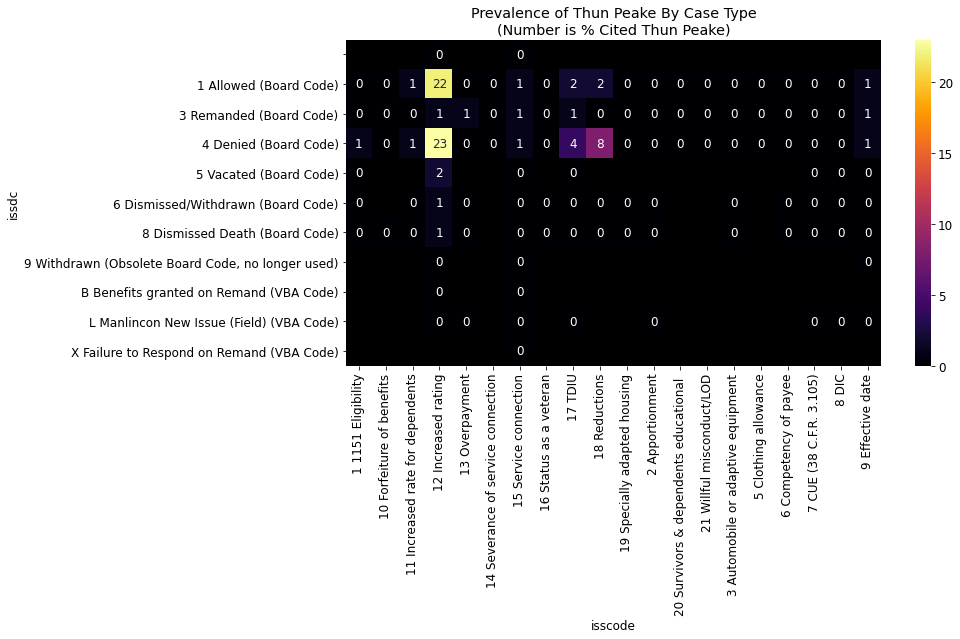

In [79]:
plot_citation_heatmap(single_issue.query("issprog == '2'"), "thun_peake", "issdc", "isscode")
_ = plt.title("Prevalence of Thun Peake By Case Type\n(Number is % Cited Thun Peake)")

In [ ]:
# labels: a tuple of (date, text, position)
def plot_citation_freq(df, case, labels):
    temp = df.groupby(pd.Grouper(key="timestamp", freq='M'))\
            .agg(count = (case, "count"),
                citations = (case, "sum"))\
            .reset_index()
    temp["timestamp"] = temp["timestamp"].astype("datetime64[ns]")
    temp["proportion"] = temp["citations"] / temp['count']
    sns.lineplot(data=temp, x="timestamp", y="proportion")
    sns.scatterplot(data=temp, x="timestamp", y="proportion")

    # Label the plot
    for label in labels:
        date, text, pos = label
        _ = plt.axvline(date, color="slategrey")
        _ = plt.annotate(text, (date2num(date), pos*np.max(temp["proportion"])), color="slategrey")
    return temp

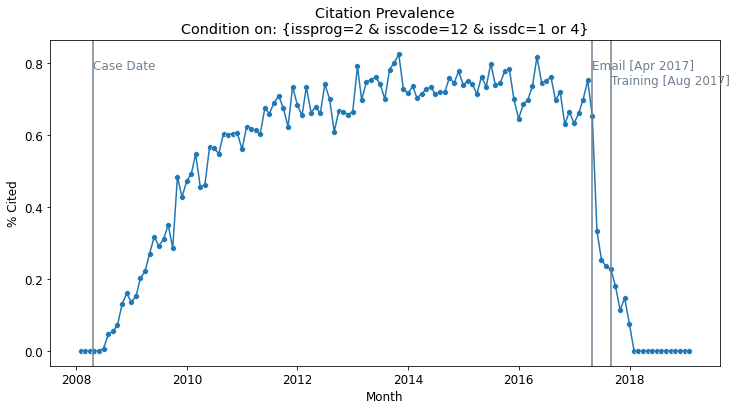

In [93]:
labels_thun_peake = [(dt.datetime(2008, 4, 21), "Case Date", 0.95),
          (dt.datetime(2017, 4, 30), "Email [Apr 2017]", 0.95),
          (dt.datetime(2017, 8, 31), "Training [Aug 2017]", 0.9)]
cond_thun_peake = "issprog == '2' & isscode == '12' & (issdc in ['1','4']) & timestamp > @pd.Timestamp('2008-01-01',tz='UTC')"
plot_data = plot_citation_freq(single_issue.query(cond_thun_peake), 
                               "thun_peake", 
                               labels=labels_thun_peake)
title = "Citation Prevalence"
title += "\nCondition on: {issprog=2 & isscode=12 & issdc=1 or 4}"
_ = plt.title(title)
_ = plt.xlabel("Month")
_ = plt.ylabel("% Cited")

In [ ]:
# labels: a tuple of (date, text, position)
def plot_appeal_rate(df, case, target, labels, periods=1):
    temp = df.groupby([pd.Grouper(key="timestamp", freq='M'), case])\
        .agg(count = (target, "count"),
             appealed = (target, "sum"))\
        .reset_index()
    temp = temp.query("count > 5")      # Omit small counts which have unstable appeal rates
    temp["proportion"] = temp["appealed"] / temp["count"]
    temp.sort_values([case, "timestamp"], inplace=True)
    temp["rolling_rate"] = temp.groupby(case).rolling(periods).proportion.mean().values
    temp["timestamp"] = temp["timestamp"].astype("datetime64[ns]")    
    sns.lineplot(data=temp, x="timestamp", y="rolling_rate", hue=case, color="slategrey", legend=False)
    sns.scatterplot(data=temp, x="timestamp", y="rolling_rate", hue=case, color="slategrey")

    # Label the plot
    for label in labels:
        date, text, pos = label
        _ = plt.axvline(date, color="slategrey")
        range_y = np.max(temp["rolling_rate"]) - np.min(temp["rolling_rate"])
        newpos = pos*range_y + np.min(temp["rolling_rate"])
        _ = plt.annotate(text, (date2num(date), newpos), color="slategrey")
    _ = plt.xlabel("Month")
    return temp

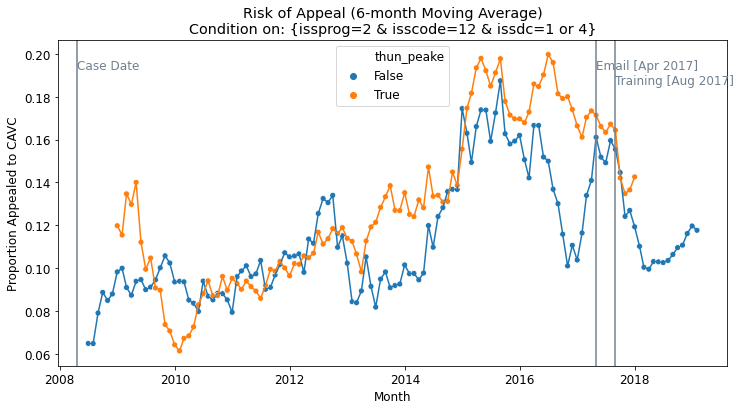

In [114]:
plt.rcParams["figure.figsize"] = [12,6]
plot_data = plot_appeal_rate(single_issue.query(cond_thun_peake), 
                             "thun_peake", 
                             target="appealed_cavc_appeal_level", 
                             labels=labels_thun_peake, 
                             periods=6)
title = "Risk of Appeal (6-month Moving Average)"
title += "\nCondition on: {issprog=2 & isscode=12 & issdc=1 or 4}"
_ = plt.title(title)
_ = plt.ylabel("Proportion Appealed to CAVC")

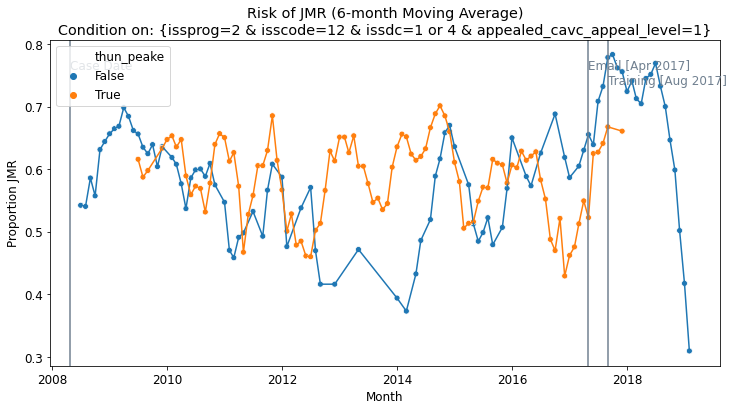

In [115]:
plot_data = plot_appeal_rate(single_issue.query(cond_thun_peake + " & appealed_cavc_appeal_level == 1"), 
                             "thun_peake", 
                             target="jmr_appeal_level", 
                             labels=labels_thun_peake, 
                             periods=6)
title = "Risk of JMR (6-month Moving Average)"
title += "\nCondition on: {issprog=2 & isscode=12 & issdc=1 or 4 & appealed_cavc_appeal_level=1}"
_ = plt.title(title)
_ = plt.ylabel("Proportion JMR")

In [ ]:
# Encode CAVC Disposition Codes
# CAVC disposition codes and labels
disp_codes = ['Unfavorable', 'Favorable', 'Other']
disp_map = {
    '1': 'Unfavorable', 
    '5': 'Unfavorable', 
    '6': 'Favorable', 
    '7': 'Favorable', 
    '8': 'Favorable', 
    '9': 'Favorable', 
    '0': 'Other', 
    'D': 'Other', 
    'N': 'Other', 
    '2': 'Other',
    '': 'Other'
}
single_issue["cvdisp_label"] = single_issue["cvdisp"].map(lambda x: disp_map[x])
single_issue["cvdisp_positive"] = single_issue["cvdisp_label"] == 'Favorable'
single_issue["cvdisp_negative"] = single_issue["cvdisp_label"] == 'Unfavorable'

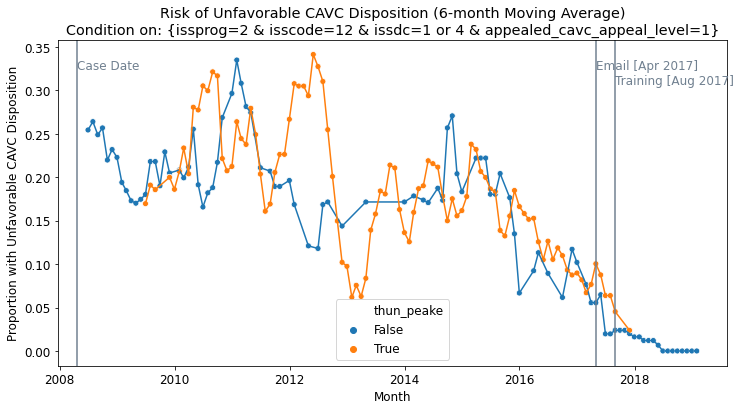

In [117]:
plot_data = plot_appeal_rate(single_issue.query(cond_thun_peake + " & appealed_cavc_appeal_level == 1"), 
                             "thun_peake", 
                             target="cvdisp_negative", 
                             labels=labels_thun_peake, periods=6)
title = "Risk of Unfavorable CAVC Disposition (6-month Moving Average)"
title += "\nCondition on: {issprog=2 & isscode=12 & issdc=1 or 4 & appealed_cavc_appeal_level=1}"
_ = plt.title(title)
_ = plt.ylabel("Proportion with Unfavorable CAVC Disposition")

### Scott v. McDonald

In [ ]:
# citation 2: Scott v. McDonald
cases = find_cases_that_cite({'case': '789 F.3d 1375'})
single_issue["scott_mcd"] = single_issue["tiread2"].isin(cases)

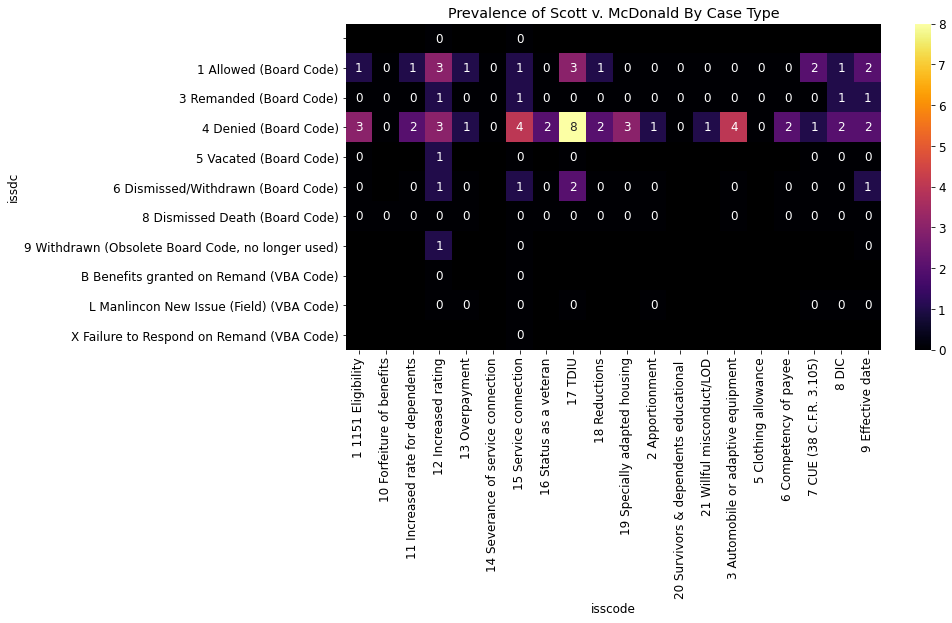

In [119]:
plot_citation_heatmap(single_issue.query("issprog == '2'"), "scott_mcd", "issdc", "isscode")
_ = plt.title("Prevalence of Scott v. McDonald By Case Type")

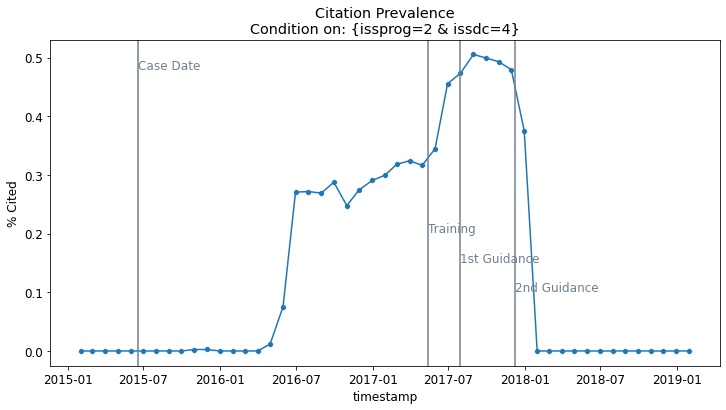

In [120]:
labels_scott_mcd = [(dt.datetime(2015, 6, 18), "Case Date", 0.95),
          (dt.datetime(2017, 5, 15), "Training", 0.4),
          (dt.datetime(2017, 7, 31), "1st Guidance", 0.3),
          (dt.datetime(2017, 12, 8), "2nd Guidance", 0.2)]
cond_scott_mcd = "issdc == '4' & issprog == '2'"
cond_scott_mcd += " & timestamp > @pd.Timestamp('2015-01-01',tz='UTC')"
plot_data = plot_citation_freq(single_issue.query(cond_scott_mcd), 
                               "scott_mcd", 
                               labels=labels_scott_mcd)
title = "Citation Prevalence"
title += "\nCondition on: {issprog=2 & issdc=4}"
_ = plt.title(title)
_ = plt.ylabel("% Cited")

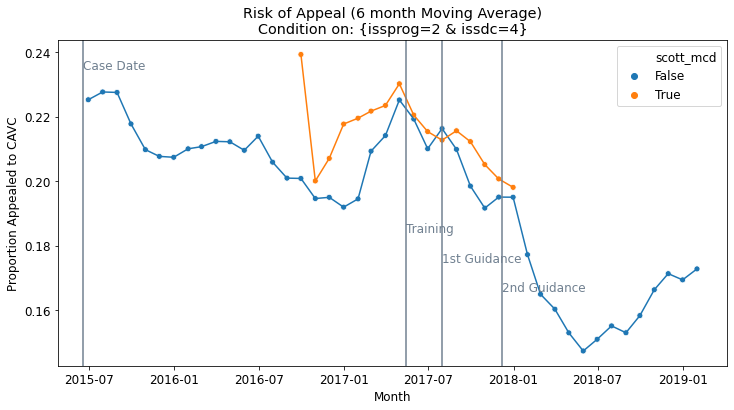

In [121]:
plot_data = plot_appeal_rate(single_issue.query(cond_scott_mcd), 
                             "scott_mcd", 
                             target="appealed_cavc_appeal_level", 
                             labels=labels_scott_mcd, 
                             periods=6)
title = "Risk of Appeal (6 month Moving Average)"
title += "\nCondition on: {issprog=2 & issdc=4}"
_ = plt.title(title)
_ = plt.ylabel("Proportion Appealed to CAVC")

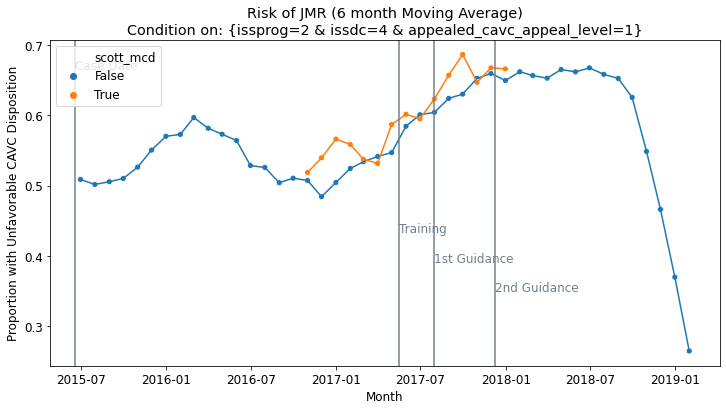

In [125]:
plot_data = plot_appeal_rate(single_issue.query(cond_scott_mcd + " & appealed_cavc_appeal_level == 1"), 
                             "scott_mcd", 
                             target="jmr_appeal_level", 
                             labels=labels_scott_mcd, 
                             periods=6)
title = "Risk of JMR (6 month Moving Average)"
title += "\nCondition on: {issprog=2 & issdc=4 & appealed_cavc_appeal_level=1}"
_ = plt.title(title)
_ = plt.xlabel("Month")
_ = plt.ylabel("Proportion with Unfavorable CAVC Disposition")

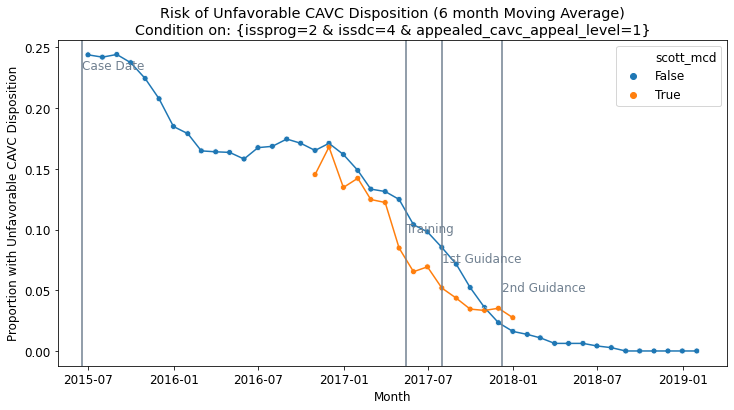

In [124]:
plot_data = plot_appeal_rate(single_issue.query(cond_scott_mcd + " & appealed_cavc_appeal_level == 1"), 
                             "scott_mcd", 
                             target="cvdisp_negative", 
                             labels=labels_scott_mcd, 
                             periods=6)
title = "Risk of Unfavorable CAVC Disposition (6 month Moving Average)"
title += "\nCondition on: {issprog=2 & issdc=4 & appealed_cavc_appeal_level=1}"
_ = plt.title(title)
_ = plt.xlabel("Month")
_ = plt.ylabel("Proportion with Unfavorable CAVC Disposition")

### Johnson v. McDonald

In [ ]:
# citation 3: Johnson v. McDonald
cases = find_cases_that_cite({'case': '762 F.3d 1362'})
single_issue["johnson_mcd"] = single_issue["tiread2"].isin(cases)

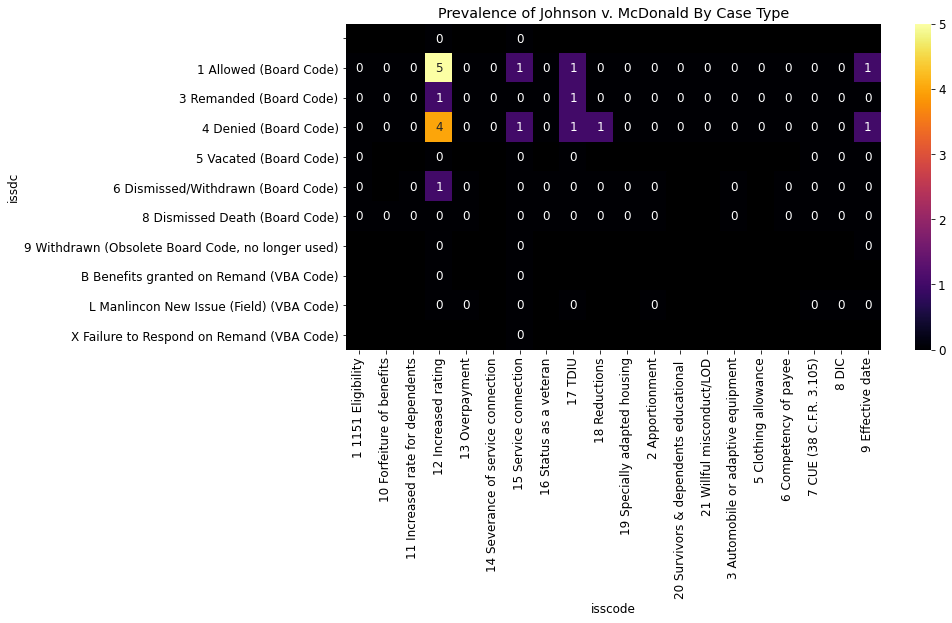

In [127]:
plot_citation_heatmap(single_issue.query("issprog == '2'"), "johnson_mcd", "issdc", "isscode")
_ = plt.title("Prevalence of Johnson v. McDonald By Case Type")

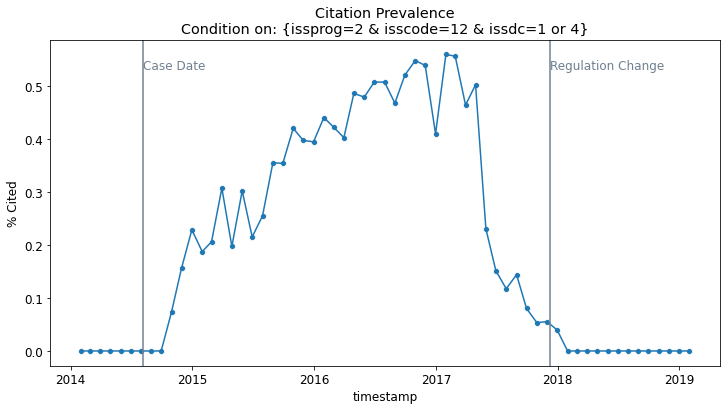

In [128]:
labels_johnson_mcd = [(dt.datetime(2014, 8, 6), "Case Date", 0.95),
                      (dt.datetime(2017, 12, 8), "Regulation Change", 0.95)]
cond_johnson_mcd = "issprog == '2' & (issdc in ['1','4']) & isscode == '12' & timestamp > @pd.Timestamp('2014-01-01',tz='UTC')"
plot_data = plot_citation_freq(single_issue.query(cond_johnson_mcd), 
                               "johnson_mcd", 
                               labels=labels_johnson_mcd)
title = "Citation Prevalence"
title += "\nCondition on: {issprog=2 & isscode=12 & issdc=1 or 4}"
_ = plt.title(title)
_ = plt.ylabel("% Cited")

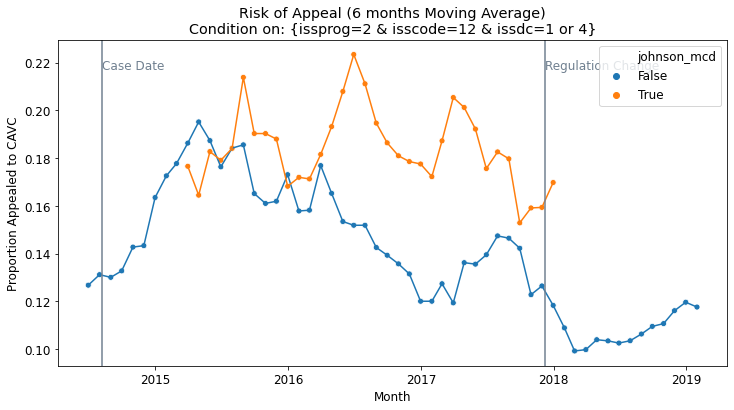

In [129]:
plot_data = plot_appeal_rate(single_issue.query(cond_johnson_mcd), 
                             "johnson_mcd", 
                             target="appealed_cavc_appeal_level", 
                             labels=labels_johnson_mcd, periods=6)
title = "Risk of Appeal (6 months Moving Average)"
title += "\nCondition on: {issprog=2 & isscode=12 & issdc=1 or 4}"
_ = plt.title(title)
_ = plt.ylabel("Proportion Appealed to CAVC")

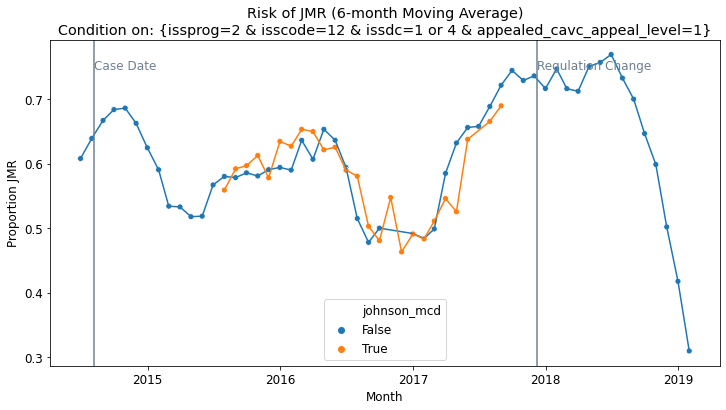

In [130]:
plot_data = plot_appeal_rate(single_issue.query(cond_johnson_mcd + " & appealed_cavc_appeal_level == 1"), 
                             "johnson_mcd", 
                             target="jmr_appeal_level", 
                             labels=labels_johnson_mcd, 
                             periods=6)
title = "Risk of JMR (6-month Moving Average)"
title += "\nCondition on: {issprog=2 & isscode=12 & issdc=1 or 4 & appealed_cavc_appeal_level=1}"
_ = plt.title(title)
_ = plt.xlabel("Month")
_ = plt.ylabel("Proportion JMR")

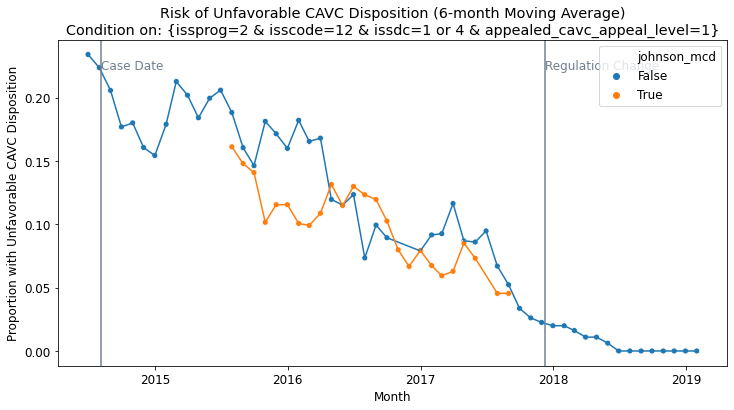

In [131]:
plot_data = plot_appeal_rate(single_issue.query(cond_johnson_mcd + " & appealed_cavc_appeal_level == 1"), 
                             "johnson_mcd", 
                             target="cvdisp_negative", 
                             labels=labels_johnson_mcd, 
                             periods=6)
title = "Risk of Unfavorable CAVC Disposition (6-month Moving Average)"
title += "\nCondition on: {issprog=2 & isscode=12 & issdc=1 or 4 & appealed_cavc_appeal_level=1}"
_ = plt.title(title)
_ = plt.xlabel("Month")
_ = plt.ylabel("Proportion with Unfavorable CAVC Disposition")